# Complete cartography

> In this experiment, we'll train on a reduced dataset with less initial conditions, and show how ML can fill the gaps in between the points in the phase space.

In [120]:
from mlchaos.all import *
from tsai.all import *
import papermill as pm
import pandas as pd
import wandb

In [121]:
if wandb.config is None:
    print('No config!!!')
else:
    print(wandb.config)

<function PreInitCallable.<locals>.preinit_wrapper at 0x7f430c89a8b0>


In [122]:
base_path = Path.home()

In [123]:
config = AttrDict(
    cartography_folderpath = base_path/'data/fli_rotnum/model_3/eps=0.01', # *
    train_cond = lambda data: (data.x[:, 1, 0] <= 0.6),
    test_cond = lambda data: data.x[:, 1, 0]> 0.6, # If None, the difference set data\train_cond will be used
    reduction_factor = 1, # One every `reduction_factor` points from the dataset will be kept
    labelling_method = 'birav'
)

In [124]:
fnames_poinc_map = [config.cartography_folderpath/'Poincare.plt']
fnames_index = [config.cartography_folderpath/'index_fli_rotnum_birav.plt']
fnames = L(fnames_poinc_map).zipwith(fnames_index)
fnames

(#1) [(Path('/home/victor/data/fli_rotnum/model_3/eps=0.01/Poincare.plt'), Path('/home/victor/data/fli_rotnum/model_3/eps=0.01/index_fli_rotnum_birav.plt'))]

In [125]:
data = TSDataChaos.from_poincare_and_index_files(fnames, index_col=index_cols[config.labelling_method])
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.01']
 Filenames:                     [(Path('/home/victor/data/fli_rotnum/model_3/eps=0.01/Poincare.plt'), Path('/home/victor/data/fli_rotnum/model_3/eps=0.01/index_fli_rotnum_birav.plt'))]
 Data shape: (10201, 2, 200)
 Targets shape: (10201,)
 Nb Samples: 10201
 Nb Channels:           2
 Sequence Length: 200

Remove the uncertain motions (class == -1)

In [126]:
data.remove_uncertainty()
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0.01']
 Filenames:                     [(Path('/home/victor/data/fli_rotnum/model_3/eps=0.01/Poincare.plt'), Path('/home/victor/data/fli_rotnum/model_3/eps=0.01/index_fli_rotnum_birav.plt'))]
 Data shape: (10165, 2, 200)
 Targets shape: (10165,)
 Nb Samples: 10165
 Nb Channels:           2
 Sequence Length: 200

In [127]:
ylims = [data.x[:, 1].min(), data.x[:, 1].max()]

[-0.550462839098462, 2.2286637844182]


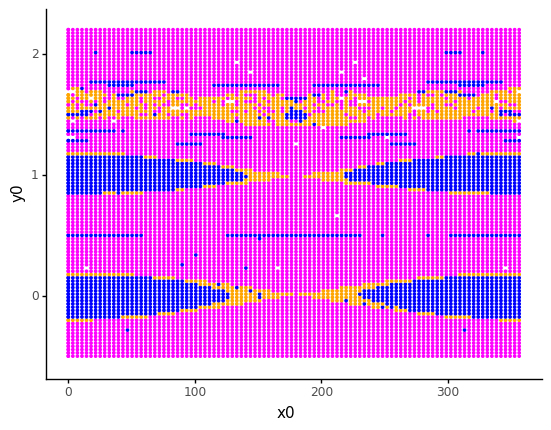

<ggplot: (8744980704335)>

In [128]:
show_labelled_ic_map(data.x, 
                     preds=data.y.astype(int), 
                     color_values=['orange', 'magenta', 'blue'])

We'll create a reduced version of this dataset, with an evenly spaced grid of points in the space

In [129]:
train_data = data.reduce(cond=config.train_cond,
                         reduction_factor=config.reduction_factor)

[-0.550462839098462, 2.2286637844182]


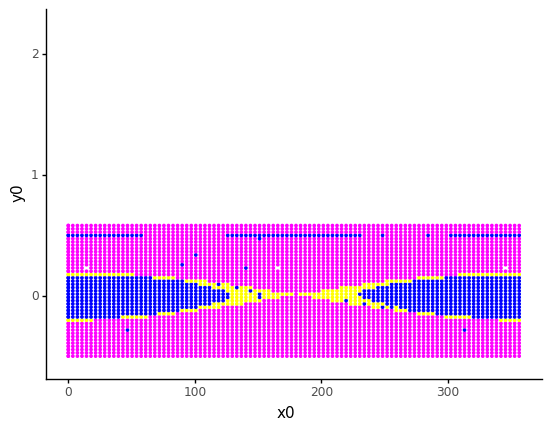

<ggplot: (8744986038905)>

In [130]:
show_labelled_ic_map(train_data.x, train_data.y.astype(int), 
                     vocab=['chaotic', 'rotational', 'librational'], 
                     color_values=dict([('chaotic', 'yellow'), 
                                   ('rotational', 'magenta'), 
                                   ('librational', 'blue')]),
                     ylim=ylims)

In [131]:
# Default data to test on remaining data from reduced dataset
test_cond = ifnone(config.test_cond, 
                  lambda data: np.mod(np.arange(data.x.shape[0]), config.reduction_factor) != 0)
test_data = data.reduce(cond=test_cond)

[-0.550462839098462, 2.2286637844182]


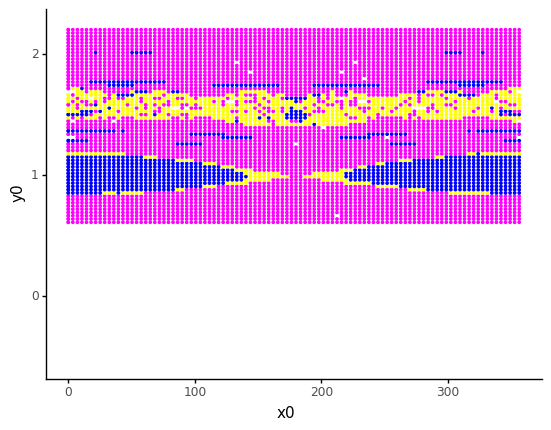

<ggplot: (8744986038941)>

In [132]:
show_labelled_ic_map(test_data.x, test_data.y.astype(int), 
                     vocab=['chaotic', 'rotational', 'librational'], 
                     color_values=dict([('chaotic', 'yellow'), 
                                   ('rotational', 'magenta'), 
                                   ('librational', 'blue')]),
                     ylim=ylims)

Dump the two datasets (reduced and test) to be used by the main program for motion classification. The reduced dataset will be used for training and the test one will be used for testing

In [133]:
tmp_train_path = base_path/'tmp_train'
tmp_test_path = base_path/'tmp_test'
poinc_fname = 'Poincare.plt'
index_fname = 'index_fli_rotnum_birav.plt'

In [138]:
tmp_train_path.mkdir(exist_ok=True)
tmp_test_path.mkdir(exist_ok=True)

In [139]:
train_data.export(tmp_train_path/poinc_fname, tmp_train_path/index_fname)
test_data.export(tmp_test_path/poinc_fname, tmp_test_path/index_fname)

Execute the notebook for motion classification with papermill, setting the config 
to point to the tmp data folders created

In [136]:
%%capture
pm.execute_notebook(base_path/'work/nbs/motion_classification_time_series.ipynb', 
                    output_path=base_path/'pm_output.ipynb', 
                    parameters={
                        'config.trainvalid_dataset_folders': [str(tmp_train_path)],
                        'config.val_ds': None,
                        'config.test_folder': str(tmp_test_path),
                        'config.labelling_method': config.labelling_method,
                        'config.resampling_period': None
                    })

In [137]:
#(tmp_train_path/poinc_fname).unlink()
#(tmp_train_path/index_fname).unlink()
#tmp_train_path.rmdir()